In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import gc
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier

from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
already_preprocessed=False
train_file='train.csv'
test_file='test.csv'

""" For Kaggle Kernels
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        if filename==train_file:
            train_dir=dirname
        if filename==test_file:
            test_dir=dirname
"""        
# Any results you write to the current directory are saved as output.

" For Kaggle Kernels\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n        if filename==train_file:\n            train_dir=dirname\n        if filename==test_file:\n            test_dir=dirname\n"

## Loading the train and test datasets


In [2]:
#root folder
root_folder='..\..'
#data_folder='.'
data_folder_name='Datasets/RooseveltForest'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))

# Both train and test set are in the root data directory
train_dir = DATA_PATH
test_dir = DATA_PATH

In [3]:
# Reading the csv file with the whole dataset
data = pd.read_csv(train_dir+'/'+train_file, sep=',', header=0, index_col=0)
# Train data, erasing label column
X_train = data.drop('Cover_Type', axis=1)
y_train = data['Cover_Type']
# Read the test data
test = pd.read_csv(test_dir+'/'+test_file, sep=',', header=0, index_col=0)

n_train=len(X_train)

## Feature engineering

Some kernels extract some new information, or new features, from the test data and then include that new information to the training dataset. A simple and effective aproach is to create a Gaussian Mixture model as is described for example in:
https://www.kaggle.com/stevegreenau/stacking-multiple-classifiers-clustering or in https://www.kaggle.com/arateris/2-layer-k-fold-learning-forest-cover

Paper: Pruthvi H.R, Nisha K.K, Chandana T.L, Navami K and Biju R M (2015) ‘Feature engineering on forest cover type data with ensemble of decision trees’, 2015 IEEE International Advance Computing Conference (IACC). Banglore, India: IEEE, pp. 1093–1098. Available at: 10.1109/IADCC.2015.7154873 (Accessed: 2 September 2019)

Lets include this new features:

In [4]:
print('Train and test dataset are equals: ',X_train.columns==test.columns)
#print(test.columns)

Train and test dataset are equals:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [5]:
from sklearn.preprocessing import StandardScaler
all_data=X_train.append(test)

scaler = StandardScaler().fit(all_data)
test_scaled = scaler.transform(test)
X_train_scaled = scaler.transform(X_train)

In [6]:
from sklearn.mixture import GaussianMixture
# Num clusters o components? 7 the same as 
# Standarscaler for test data?

gmix = GaussianMixture(n_components=10)
gmix.fit(test_scaled)

x_train_gmix = gmix.predict(X_train_scaled)
test_gmix = gmix.predict(test_scaled)

In [7]:
#X_train = np.hstack((X_train, np.reshape(x_train_gmix,(x_train_gmix.shape[0],1))))
#test = np.hstack((test, np.reshape(test_gmix,(test_gmix.shape[0],1))))
X_train['Cluster_Test']=x_train_gmix
test['Cluster_Test']=test_gmix

#Convert to categorical
X_train = pd.get_dummies(X_train,columns = ['Cluster_Test'])
test = pd.get_dummies(test,columns = ['Cluster_Test'])

print(test.shape,X_train.shape)

(565892, 64) (15120, 64)


In [53]:
#Apply PCA to obtain new features based in all datasets (train and test)
def add_PCA_features(X):
    pca = PCA(n_components=0.99, random_state=0).fit(X)
    X_pca = pca.transform(X)
    
    return X_pca

components = add_PCA_features(all_data)

print('PCA components dimension: ',components.shape)

for i in range(components.shape[1]):
    col_name= 'pca'+str(i+1)
    X_train[col_name] = components[:n_train, i]
    test[col_name] = components[n_train:, i]

print(test.shape,X_train.shape)

PCA components dimension:  (581012, 4)
(565892, 59) (15120, 59)


We will apply some oversampling on the training data, trying to solve the results of confussion matrix. There are many classifications errors in samples of cover type 1 and 2, so we want to train the model with more examples of these cover types.

Many ideas and tricks extracted from a great kernell: https://www.kaggle.com/phsheth/forestml-part-6-stacking-selfets-gmix-smote by https://www.kaggle.com/phsheth

In [8]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = {1:8000, 2:8000, 3:3000, 4:3000, 5:3000, 6:3000, 7:3000}, random_state=0)

X_sm, y_sm = sm.fit_sample(X_train, y_train.ravel())

Using TensorFlow backend.
C:\Users\edumu\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:253: UserWarning: After over-sampling, the number of samples (8000) in class 1 will be larger than the number of samples in the majority class (class #1 -> 2160)
  n_samples_majority))
C:\Users\edumu\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:253: UserWarning: After over-sampling, the number of samples (8000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 2160)
  n_samples_majority))
C:\Users\edumu\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:253: UserWarning: After over-sampling, the number of samples (3000) in class 3 will be larger than the number of samples in the majority class (class #1 -> 2160)
  n_samples_majority))
C:\Users\edumu\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:253: UserWarning: After over-sampling, the number of samples (3000) in class 4 will be larger than the number of samples in the

In [9]:
print('After OverSampling, the shape of train_X: {}'.format(X_sm.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_sm.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_sm==1)))
print("After OverSampling, counts of label '2': {}".format(sum(y_sm==2)))
print("After OverSampling, counts of label '3': {}".format(sum(y_sm==3)))
print("After OverSampling, counts of label '4': {}".format(sum(y_sm==4)))
print("After OverSampling, counts of label '5': {}".format(sum(y_sm==5)))
print("After OverSampling, counts of label '6': {}".format(sum(y_sm==6)))
print("After OverSampling, counts of label '7': {}".format(sum(y_sm==7)))

After OverSampling, the shape of train_X: (31000, 55)
After OverSampling, the shape of train_y: (31000,)
After OverSampling, counts of label '1': 8000
After OverSampling, counts of label '2': 8000
After OverSampling, counts of label '3': 3000
After OverSampling, counts of label '4': 3000
After OverSampling, counts of label '5': 3000
After OverSampling, counts of label '6': 3000
After OverSampling, counts of label '7': 3000


Now we can replace the original training dataset with the new one oversampled

In [10]:
X_train=pd.DataFrame(data=X_sm, columns=X_train.columns)
X_train.index.name='Id'

In [11]:
y_train=pd.Series(y_sm)
y_train.index.name='Id'
y_train.name='Cover_Type'
y_train

Id
0        5
1        5
2        2
3        2
4        5
        ..
30995    7
30996    7
30997    7
30998    7
30999    7
Name: Cover_Type, Length: 31000, dtype: int64

In [12]:
y_train

Id
0        5
1        5
2        2
3        2
4        5
        ..
30995    7
30996    7
30997    7
30998    7
30999    7
Name: Cover_Type, Length: 31000, dtype: int64

## Feature Selection
In this kernell we are goint to generate a group of features that many others competitors have worked on and looks loke they can produce a grat result. Thanks to kwabenantim, most of the feature engineering and selection in this kernells have been extracted from his excellent kernell https://www.kaggle.com/kwabenantim/forest-cover-stacking-multiple-classifiers. I stringllly recomend to read carefully and study it, not all the steps in that kernell are included in this one. This one is simpler and very easy to understand.


In [54]:
# Plot the feature importance determined by the classifier clf
def feature_importances(clf, X, y):
    clf = clf.fit(X, y)
    
    importances = pd.DataFrame({'Features': X.columns, 
                                'Importances': clf.feature_importances_})
    
    importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

    fig = plt.figure(figsize=(14, 4))
    sns.barplot(x='Features', y='Importances', data=importances)
    plt.xticks(rotation='vertical')
    plt.show()
    
# Calculate the accuracy using a cross validated approach 
def cv_accuracy(clf, X, y):
    scores = cross_val_score(clf, X, y, 
                             cv=5, 
                             scoring='accuracy',
                             verbose=0, 
                             n_jobs=-1)
    
    print('Cross-validation accuracy: {:.3f} {}'.format(np.mean(scores),  
                                                        np.around(scores, 3)))

# Shows the confusion matrix using criss validated predictions
def cv_confusion(clf, X, y):
    prediction = cross_val_predict(clf, X, y, 
                                   cv=5, 
                                   verbose=0, 
                                   n_jobs=-1)
    
    classes = sorted(y.unique().tolist())

    conf_mat = confusion_matrix(y, prediction)
    norm_conf_mat = np.around(conf_mat / conf_mat.sum(axis=1), 2)

    fig = plt.figure(figsize=(14, 8))

    fig.add_subplot(1, 2, 1)
    ax = sns.heatmap(norm_conf_mat, annot=True, cmap='OrRd', 
                     xticklabels=classes, yticklabels=classes)
    ax.set(xlabel='Predicted Class', ylabel='True Class', title='Normalized')


    fig.add_subplot(1, 2, 2)
    ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='OrRd', 
                     xticklabels=classes, yticklabels=classes)
    ax.set(xlabel='Predicted Class', ylabel='True Class', title ='Counts')

    #plt.tight_layout()
    plt.show()
    
# Plot correlations between numerical features
def plot_correlations(X, annot=False):
    numericals = [col for col in X.columns if 
                  'Soil_Type' not in col and 
                  'Wilderness_Area' not in col]

    numericals = sorted(numericals)

    # Place correlations in four bins
    corr = np.around(X[numericals].corr().abs(), 1)
    
    corr_bin = corr.copy()
    corr_bin = corr_bin.where(corr_bin > 0.30, 0.30)

    corr_bin = corr_bin.where((corr_bin <= 0.30) | 
                              (corr_bin > 0.50), 0.50)

    corr_bin = corr_bin.where((corr_bin <= 0.50) | 
                              (corr_bin > 0.70), 0.70)

    corr_bin = corr_bin.where(corr_bin <= 0.70, 1.0)
    
    if annot:
        annot = corr
        
    # Show binned correlation plot
    fig = plt.figure(figsize=(12, 12))
    sns.heatmap(corr_bin, annot=annot, linewidths=1, square=True, 
                cmap='BuPu', cbar_kws={'shrink':0.5})
    plt.title('Feature Correlations')
    plt.show()

# Drop features with mode frequency > 99% of data
# Those columns are irrelevant, they have almost just one value 
def drop_unimportant(X_):
    X = X_.copy()
    
    n_rows = X.shape[0]
    hi_freq_cols = []
    
    for col in X.columns:
        mode_frequency = 100.0 * X[col].value_counts().iat[0] / n_rows 
        
        if mode_frequency > 99.0:
            hi_freq_cols.append(col)
            
    X = X.drop(hi_freq_cols, axis='columns')
    
    return hi_freq_cols,X

def drop_correlated(X_):
    X = X_.copy()
    
    drop_cols = ['Hillshade_mean', 'Hillshade_median', 'Hillshade_max', 
                 'Hillshade_min', 'Hillshade_sum', 'Hydro_Elevation_sum',
                 'Hydro_Distance_sum', 'Hydro_Distance_diff', 'Hydro_Fire_mean', 
                 'Hydro_Fire_median', 'Hydro_Manhattan', 'Hydro_Road_Fire_mean', 
                 'Hydro_Road_Fire_median', 'Hydro_Road_mean', 'Hydro_Road_median', 
                 'Road_Fire_mean', 'Road_Fire_median']
    
    drop_cols = [col for col in drop_cols if col in X.columns]
    
    X = X.drop(drop_cols, axis='columns')
    
    return drop_cols,X


We will use a simple RandomForest classifier to analyze the features, it will be the performance baseline 

In [55]:
#This classifier is used to evaluate the performance of the features in diferent scenarios: importance, correlation and so.
clf = RandomForestClassifier(n_estimators=125,
                             min_samples_leaf=1,
                             max_depth=None,
                             verbose=0,
                             random_state=0)

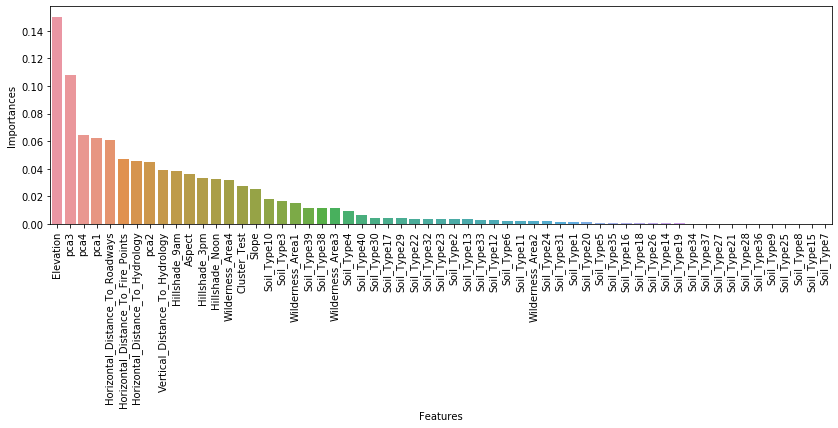

Cross-validation accuracy: 0.799 [0.771 0.766 0.787 0.81  0.862]


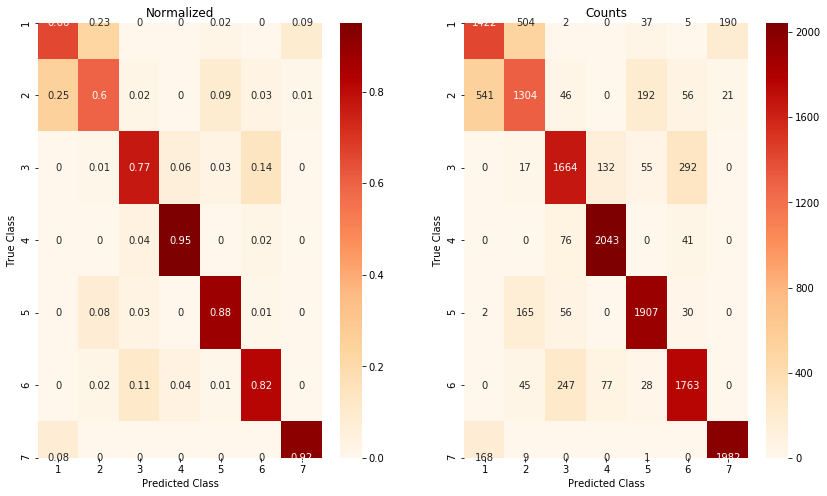

In [56]:
feature_importances(clf, X_train, y_train)
cv_accuracy(clf, X_train, y_train)
cv_confusion(clf, X_train, y_train)

In [57]:
# This new features has been extracted from the kernel previously citated:
# https://www.kaggle.com/kwabenantim/forest-cover-stacking-multiple-classifiers

#Missing values for hillshade 3am
def add_features(X_):
    X = X_.copy()
    
    X['Hydro_Elevation_sum'] = X[['Elevation',
                                  'Vertical_Distance_To_Hydrology']
                                 ].sum(axis='columns')
    
    X['Hydro_Elevation_diff'] = X[['Elevation',
                                   'Vertical_Distance_To_Hydrology']
                                  ].diff(axis='columns').iloc[:, [1]]

    X['Hydro_Euclidean'] = np.sqrt(X['Horizontal_Distance_To_Hydrology']**2 +
                                   X['Vertical_Distance_To_Hydrology']**2)

    X['Hydro_Manhattan'] = (X['Horizontal_Distance_To_Hydrology'] +
                            X['Vertical_Distance_To_Hydrology'].abs())
    
    
    X['Hydro_Distance_sum'] = X[['Horizontal_Distance_To_Hydrology',
                                 'Vertical_Distance_To_Hydrology']
                                ].sum(axis='columns')

    X['Hydro_Distance_diff'] = X[['Horizontal_Distance_To_Hydrology',
                                  'Vertical_Distance_To_Hydrology']
                                 ].diff(axis='columns').iloc[:, [1]]
    
    X['Hydro_Fire_sum'] = X[['Horizontal_Distance_To_Hydrology',
                             'Horizontal_Distance_To_Fire_Points']
                            ].sum(axis='columns')

    X['Hydro_Fire_diff'] = X[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Fire_Points']
                             ].diff(axis='columns').iloc[:, [1]].abs()

    X['Hydro_Fire_mean'] = X[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Fire_Points']
                             ].mean(axis='columns')

    X['Hydro_Fire_median'] = X[['Horizontal_Distance_To_Hydrology',
                                'Horizontal_Distance_To_Fire_Points']
                               ].median(axis='columns')
                               
    X['Hydro_Road_sum'] = X[['Horizontal_Distance_To_Hydrology',
                             'Horizontal_Distance_To_Roadways']
                            ].sum(axis='columns')

    X['Hydro_Road_diff'] = X[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Roadways']
                             ].diff(axis='columns').iloc[:, [1]].abs()

    X['Hydro_Road_mean'] = X[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Roadways']
                             ].mean(axis='columns')

    X['Hydro_Road_median'] = X[['Horizontal_Distance_To_Hydrology',
                                'Horizontal_Distance_To_Roadways']
                               ].median(axis='columns')
    
    X['Road_Fire_sum'] = X[['Horizontal_Distance_To_Roadways',
                            'Horizontal_Distance_To_Fire_Points']
                           ].sum(axis='columns')

    X['Road_Fire_diff'] = X[['Horizontal_Distance_To_Roadways',
                             'Horizontal_Distance_To_Fire_Points']
                            ].diff(axis='columns').iloc[:, [1]].abs()

    X['Road_Fire_mean'] = X[['Horizontal_Distance_To_Roadways',
                             'Horizontal_Distance_To_Fire_Points']
                            ].mean(axis='columns')

    X['Road_Fire_median'] = X[['Horizontal_Distance_To_Roadways',
                               'Horizontal_Distance_To_Fire_Points']
                              ].median(axis='columns')
    
    X['Hydro_Road_Fire_mean'] = X[['Horizontal_Distance_To_Hydrology',
                                   'Horizontal_Distance_To_Roadways',
                                   'Horizontal_Distance_To_Fire_Points']
                                  ].mean(axis='columns')

    X['Hydro_Road_Fire_median'] = X[['Horizontal_Distance_To_Hydrology',
                                     'Horizontal_Distance_To_Roadways',
                                     'Horizontal_Distance_To_Fire_Points']
                                    ].median(axis='columns')

    X['Hillshade_sum'] = X[['Hillshade_9am',
                            'Hillshade_Noon',
                            'Hillshade_3pm']
                           ].sum(axis='columns')

    X['Hillshade_mean'] = X[['Hillshade_9am',
                             'Hillshade_Noon',
                             'Hillshade_3pm']
                            ].mean(axis='columns')

    X['Hillshade_median'] = X[['Hillshade_9am',
                               'Hillshade_Noon',
                               'Hillshade_3pm']
                              ].median(axis='columns')

    X['Hillshade_min'] = X[['Hillshade_9am',
                            'Hillshade_Noon',
                            'Hillshade_3pm']
                           ].min(axis='columns')

    X['Hillshade_max'] = X[['Hillshade_9am',
                            'Hillshade_Noon',
                            'Hillshade_3pm']
                           ].max(axis='columns')
        
    # Compute Soil_Type number from Soil_Type binary columns
    X['Stoneyness'] = sum(i * X['Soil_Type{}'.format(i)] for i in range(1, 41))
    
    # For all 40 Soil_Types, 1=rubbly, 2=stony, 3=very stony, 4=extremely stony, 0=?
    stoneyness = [4, 3, 1, 1, 1, 2, 0, 0, 3, 1, 
                  1, 2, 1, 0, 0, 0, 0, 3, 0, 0, 
                  0, 4, 0, 4, 4, 3, 4, 4, 4, 4, 
                  4, 4, 4, 4, 1, 4, 4, 4, 4, 4]
    
    # Replace Soil_Type number with "stoneyness" value
    X['Stoneyness'] = X['Stoneyness'].replace(range(1, 41), stoneyness)

    return X

We will repeat the previous analyze with our new dataset, containing the new features

In [58]:
# Add the new features to the dataset
X_train = add_features(X_train)
test = add_features(test)

print(test.shape,X_train.shape)

#feature_importances(clf, X_train, y_train)
#cv_accuracy(clf, X_train, y_train)
#cv_confusion(clf, X_train, y_train)

(565892, 85) (15120, 85)


Finally we will drop unimportant features, those containing just a few values. Mode frequency > 99% of data. And the last step will be to drop those correlated features.

In [59]:
# Drop umportant columns from train data
unimportant_cols,X_train = drop_unimportant(X_train)

#cv_accuracy(clf, X_train, y_train)
# Drop umportant columns from test data
test = test.drop(unimportant_cols, axis='columns')
print(test.shape,X_train.shape)

(565892, 68) (15120, 68)


Drop correlated columns they usually do not provide information for a better classifier but they can overfit out model

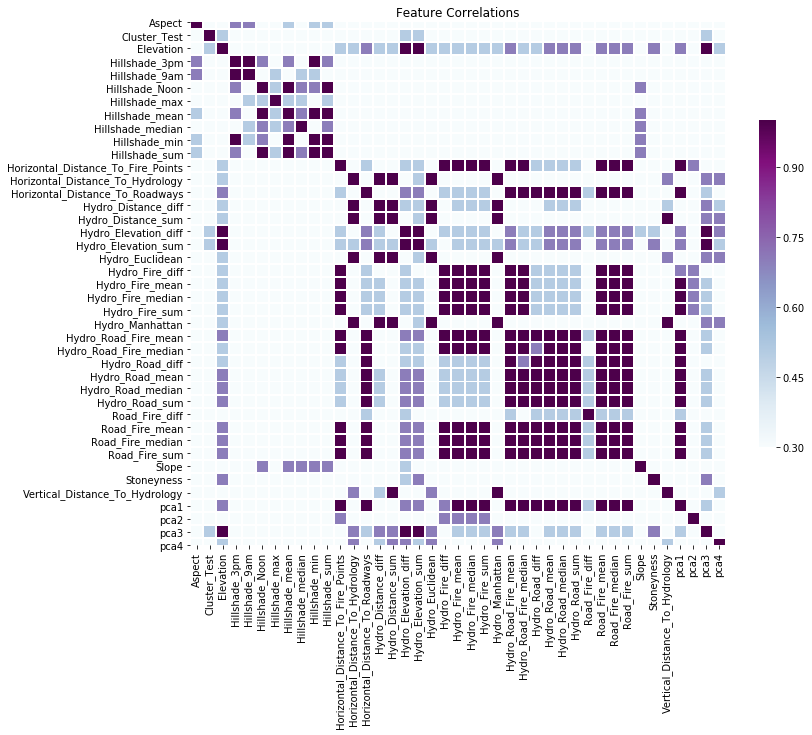

(565892, 51) (15120, 51)


In [61]:
plot_correlations(X_train, annot=False)
#Drop correlated columns from test data
dropped_cols, X_train = drop_correlated(X_train)
#Drop correlated columns from test data
test = test.drop(dropped_cols, axis='columns')
print(test.shape,X_train.shape)

## Apply RFE to select the features 

The Recursive Feature Elimination (RFE) method is a feature selection approach. It works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.


In [17]:
from sklearn.feature_selection import RFE

rfe = RFE(clf, n_features_to_select = None, step=1)
# Fit the classifier and extract the features selected
selector= rfe.fit(X_train, y_train)


In [18]:
#print(selector.n_features_,selector.ranking_)
#X_train = selector.transform(X_train)
def drop_unranked(X_,cols,rank = 1):
    ''' Drop the columns in X_ which RFE ranking is higher that the rank parameter'''
    X = X_.copy()
    # Select the columns to drop
    drop_cols = [X.columns[i] for i in range(0,len(X.columns)) if cols[i]>rank]
    
    # Drop the columns
    X = X.drop(drop_cols, axis='columns')
    
    return drop_cols,X

In [25]:
print('Selected columns: ',sum(selector.ranking_<=5))

cols,X_train=drop_unranked(X_train,selector.ranking_, 5)
test = test.drop(cols, axis='columns')

Seleccionables:  27


Evaluate the final dataset after removing some unrelevant features in the previous steps

(565892, 45) (31000, 45)
Cross-validation accuracy: 0.933 [0.899 0.92  0.945 0.958 0.945]


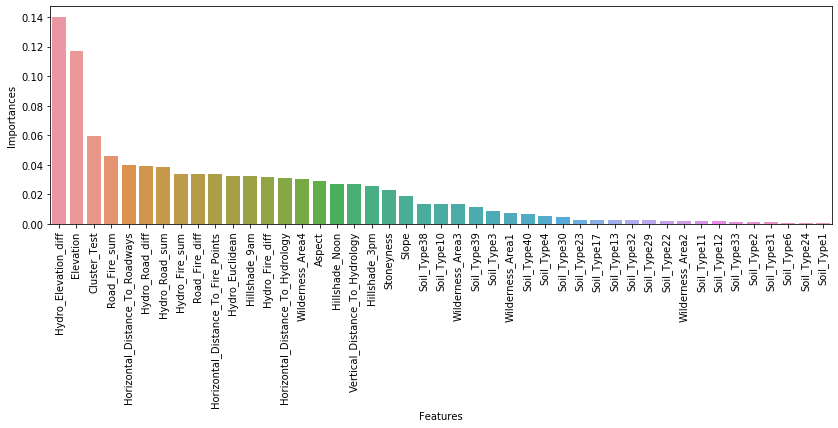

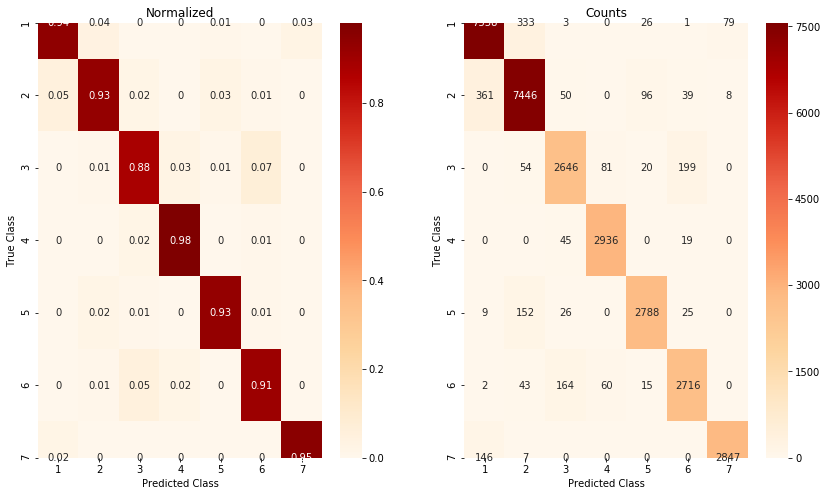

In [42]:
#Lets evaluate our final dataset
print(test.shape,X_train.shape)

cv_accuracy(clf, X_train, y_train)
feature_importances(clf, X_train, y_train)
cv_confusion(clf, X_train, y_train)

Lets save the final train and test dataset to be use in the classifiers

In [43]:
df1 = X_train.assign(Cover_Type=y_train)
df1.to_csv('train_fe.csv', sep=',', header=True, index=True, index_label='Id')
test.to_csv('test_fe.csv', sep=',', header=True, index=True, index_label='Id')

In [62]:
# Tranform to numpy array of float type
X = X_train.values.astype('float64')
y = y_train.values.ravel()
test_ds= test.values.astype('float64')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

print('X: ', X.shape)
print('y: ', y.shape)
print('test: ', test_ds.shape)

X:  (15120, 51)
y:  (15120,)
test:  (565892, 51)


## Classifiers for Level 1 in the stacked model

Create a dictionary of the diferents models for Level 1 in the stacked model. There are many posibilities, I have tested some of them using GridSearchCV for some parameter tunning (but they can be improved with some other experiments). You can check some great kernels publish by others members:

https://www.kaggle.com/stevegreenau/stacking-multiple-classifiers-clustering
https://www.kaggle.com/phsheth/forestml-part-6-stacking-selfets-gmix-smote

Bayesian optimization for hyperparameters. ¿Try?
https://www.kdnuggets.com/2019/07/xgboost-random-forest-bayesian-optimisation.html


In [14]:
#Define a ratio for every class weighted
#ratio_weight={1:0.3, 2:0.3, 3: 0.1, 4:0.05, 5:0.1, 6:0.1, 7:0.05}
ratio_weight={1:0.3, 2:0.3, 3: 0.1, 4:0.05, 5:0.1, 6:0.1, 7:0.05}

In [63]:
#Estimators: 400, 400, 400, 125 (reduce to 100 100 100 100 for some tests)
models = {
    'Random Forest': RandomForestClassifier(criterion = 'gini',n_estimators=400, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                    max_leaf_nodes=None,random_state = 0, class_weight = None),
    'AdaBoost': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion = 'gini', max_depth=None, min_samples_split=2,
                                                                         min_samples_leaf=1,max_leaf_nodes=None,max_features='auto',
                                                                         random_state = 0, class_weight = None),
                                   n_estimators=400,learning_rate=0.2,random_state=0),
    'Bagging': BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion = 'gini', max_depth=None, min_samples_split=2,
                                                                         min_samples_leaf=1,max_leaf_nodes=None,max_features='auto',
                                                                         random_state = 0),
                                  n_estimators=300,max_features=0.75, max_samples=1.0, random_state=0,n_jobs=-1,verbose=0),
    'LGBM': LGBMClassifier(n_estimators=400, learning_rate= 0.1, objective= 'multiclass', num_class=7, random_state= 0, 
                           n_jobs=-1, class_weight = None),
    #'KNN': KNeighborsClassifier(n_neighbors=7, n_jobs=-1),
    'Extra Tree': ExtraTreesClassifier(criterion = 'entropy', n_estimators=250, max_depth=None, min_samples_split=2,min_samples_leaf=1, 
                                      max_leaf_nodes=None,oob_score=False, warm_start=True, random_state = 0, 
                                      class_weight = None)
}

'''    
    'Bagging': BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion = 'entropy', max_depth=None, min_samples_split=2,
                                                                         min_samples_leaf=1,max_leaf_nodes=None,max_features='auto',
                                                                         random_state = 0),
                                   n_estimators=300,max_features=0.75, max_samples=1.0, random_state=0,n_jobs=-1,verbose=0),
    #{'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 300}
    #'GBM': GradientBoostingClassifier(n_estimators=500, learning_rate= 0.2, max_depth=10, min_samples_leaf=1, 
    #                                  min_samples_split=2,random_state=0,verbose=1),
    'LGBM': LGBMClassifier(n_estimators=300, learning_rate= 0.1, objective= 'multiclass', num_class=7, random_state= 0, 
                           n_jobs=-1, class_weight = ratio_weight),
    #'LGBM': LGBMClassifier(n_estimators=300, num_leaves=100, verbosity=0, random_state=0,n_jobs=-1),
    'KNN': KNeighborsClassifier(n_neighbors=7, n_jobs=-1),
    # 'XGB': XGBClassifier(n_estimator= 200, learning_rate= 0.1, max_depth= 50, objective= 'binary:logistic',random_state= 0,n_jobs=-1),
    'Extra Tree': ExtraTreesClassifier(criterion = 'entropy', n_estimators=150, max_depth=None, min_samples_split=2,min_samples_leaf=1, 
                                      max_leaf_nodes=None,oob_score=False, warm_start=True, random_state = 0, 
                                      class_weight = ratio_weight)
'''

"    \n    'Bagging': BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion = 'entropy', max_depth=None, min_samples_split=2,\n                                                                         min_samples_leaf=1,max_leaf_nodes=None,max_features='auto',\n                                                                         random_state = 0),\n                                   n_estimators=300,max_features=0.75, max_samples=1.0, random_state=0,n_jobs=-1,verbose=0),\n    #{'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 300}\n    #'GBM': GradientBoostingClassifier(n_estimators=500, learning_rate= 0.2, max_depth=10, min_samples_leaf=1, \n    #                                  min_samples_split=2,random_state=0,verbose=1),\n    'LGBM': LGBMClassifier(n_estimators=300, learning_rate= 0.1, objective= 'multiclass', num_class=7, random_state= 0, \n                           n_jobs=-1, class_weight = ratio_weight),\n    #'LGBM': LGBMClassifier(n_estimators=300, n

In [64]:
models

{'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=400,
                        n_jobs=None, oob_score=False, random_state=0, verbose=0,
                        warm_start=False),
 'AdaBoost': AdaBoostClassifier(algorithm='SAMME.R',
                    base_estimator=DecisionTreeClassifier(class_weight=None,
                                                          criterion='entropy',
                                                          max_depth=None,
                                                          max_features='auto',
                                                          max_leaf_nodes=None,
                                           

Lets evaluate our level-1 classifiers using cross validation, splits = 5

In [65]:
from sklearn.model_selection import KFold, cross_val_score

# Create the splits for cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=0)

In [121]:
# Evaluate the L1 classifiers (not necessary)
results= dict()
for name, model in models.items():
    print('Evaluating Model: ',name)
    cv_results = cross_val_score(model, X, y,
                                cv=cv, 
                                scoring='accuracy')
    results[name] = cv_results
    print(name, 'Accuracy Mean {0:.4f}, Std {1:.4f}'.format(
              cv_results.mean(), cv_results.std()))

accuracies= dict()
for name, accs in results.items():
    accuracies[name]=accs.mean()
    
best_model=max(accuracies, key=accuracies.get)
print('Best Model: ',best_model,' Accuracy: ',accuracies[best_model])

Evaluating Model:  Random Forest
Random Forest Accuracy Mean 0.8919, Std 0.0061
Evaluating Model:  AdaBoost
AdaBoost Accuracy Mean 0.7937, Std 0.0082
Evaluating Model:  GBM
      Iter       Train Loss   Remaining Time 
         1       13667.7726            5.22m
         2        9898.4484            7.07m
         3        7517.9394            7.55m
         4        5743.3423            7.82m
         5        4524.4453            8.02m
         6        3626.1486            8.18m
         7        2970.6414            8.29m
         8        2425.3214            8.36m
         9        2000.5692            8.43m
        10        1671.6210            8.53m
        20         448.6706            8.55m
        30         169.9908            7.91m
        40          69.1669            7.38m
        50          30.9718            6.80m
        60          15.3047            6.28m
        70           8.3592            5.72m
        80           5.5700            5.14m
        90      

## Classifier for Level 2 of the Stacked model
Now we have determined the best model and its accuracy, so the next step is to create a stacked model whose L1 classifiers are the previuos models and the meta-classifier (L2 classifier) will be the best model. Finally we will test the model using prediction probabilities in L1 and adding or not the features

In [66]:
def L1_train_pred_proba(clf,clf_name,X_train,y_train,X_test):
    #clf_newcols=[str(clf_name)+str(i+1) for i in range(7)]
    #Train the classifier on the training dataset
    clf.fit(X_train,y_train)
    #Predict on the training dataset and save the results
    train_probas=clf.predict_proba(X_train)
    #Predict on the test dataset
    test_probas=clf.predict_proba(X_test)
    
    return train_probas,test_probas


In [44]:
#models.keys()
clf_name=[*models][0]
clf=models[clf_name]

In [67]:
#meta_model=models[best_model]
meta_model=RandomForestClassifier(criterion = 'entropy',n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                    max_leaf_nodes=None,random_state = 0)
#meta_model=LogisticRegression(max_iter=1000, n_jobs=-1, solver= 'lbfgs',multi_class = 'multinomial')

In [68]:
X_train_prob_preds=X_train.copy()
X_test_prob_preds=test.copy()

for clf_name,clf in models.items():
    print(clf_name)
    train_probas, test_probas=L1_train_pred_proba(clf,clf_name,X,y,test_ds)
    
    X_train_prob_preds=np.concatenate((X_train_prob_preds,train_probas),axis=1)
    X_test_prob_preds=np.concatenate((X_test_prob_preds,test_probas),axis=1)



Random Forest
AdaBoost
Bagging
LGBM
KNN
Extra Tree


In [69]:
X_train_prob_preds[0]

array([ 2.59600000e+03,  5.10000000e+01,  3.00000000e+00,  2.58000000e+02,
        0.00000000e+00,  5.10000000e+02,  2.21000000e+02,  2.32000000e+02,
        1.48000000e+02,  6.27900000e+03,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.74821965e+02,  4.63459937e+03,
       -2.44289792e+02,  1.07119699e+02, -2.59600000e+03,  2.58000000e+02,
        6.53700000e+03,  6.02100000e+03,  7.68000000e+02,  2.52000000e+02,
        6.78900000e+03,  5.76900000e+03,  4.00000000e+00,  0.00000000e+00,
        2.25000000e-02,  

In [71]:
#Now it is time to train the meta-classifier (L1) with the train data including the predicted probabilities of all L1 classifiers
meta_model.fit(X_train_prob_preds,y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [72]:
predictions = meta_model.predict(X_train_prob_preds)
predictions_test = meta_model.predict(X_test_prob_preds)
print('Stacked Model Accuracy: ',round(accuracy_score(y, predictions),4))

Stacked Model Accuracy:  1.0


In [70]:
print(X_train_prob_preds.shape,X_train.shape)
print(X_test_prob_preds.shape,test.shape)


(15120, 93) (15120, 51)
(565892, 93) (565892, 51)


In [26]:
#It is time for evaluating the stacked model
scores = cross_val_score(meta_model, X_train_prob_preds, y, cv=cv, scoring='accuracy', verbose=0)

print('Accuracy: %0.4f (+/- %0.4f)' % (scores.mean(), scores.std()))

Accuracy: 1.0000 (+/- 0.0000)


Finally we will predict on the training and test data to get the final results 

Save the input meta-features to L1 classifier, it can be used in another kind of model as a NN

In [73]:
df= pd.DataFrame(data=X_train_prob_preds, index=X_train.index.values)
df.to_csv("data_meta_features_L2_train.csv", index=True)

In [74]:
#metaf.shape
#stacked_model.meta-features
df= pd.DataFrame(data=X_test_prob_preds, index=test.index.values)
df.to_csv("data_meta_features_L2_test.csv", index=True)

### Generate a submission file with the predictions

Create the submission file with the predictions for the test dataset and then we upload the file to Kaggle.

In [75]:
submission = pd.DataFrame({ 'Id': test.index.values,
                            'Cover_Type': predictions_test })
submission.to_csv("submission_data.csv", index=False)

In [76]:
!kaggle  competitions  submit -c learn-together -f submission_data.csv -m "FE 10-c PCA L1:RF Ada LGBM ET BAG KNN L2:RF"

Successfully submitted to Learn With Other Kaggle Users



  0%|          | 0.00/5.32M [00:00<?, ?B/s]
  8%|8         | 440k/5.32M [00:00<00:01, 4.12MB/s]
 43%|####3     | 2.30M/5.32M [00:00<00:00, 5.37MB/s]
 55%|#####4    | 2.91M/5.32M [00:01<00:01, 1.77MB/s]
 82%|########2 | 4.36M/5.32M [00:01<00:00, 2.38MB/s]
 95%|#########4| 5.04M/5.32M [00:01<00:00, 2.21MB/s]
100%|##########| 5.32M/5.32M [00:04<00:00, 1.16MB/s]


In [77]:
!kaggle competitions submissions -c learn-together -q

fileName                                 date                 description                                                      status    publicScore  privateScore  
---------------------------------------  -------------------  ---------------------------------------------------------------  --------  -----------  ------------  
submission_data.csv                      2019-10-09 18:18:52  FE 10-c PCA L1:RF Ada LGBM ET BAG KNN L2:RF                      complete  0.79693      None          
Feature eng. and a simple Stacked model  2019-10-08 17:45:22  From "Feature eng. and a simple Stacked model" Script            complete  0.82529      None          
Feature eng. and a simple Stacked model  2019-10-08 17:11:01  From "Feature eng. and a simple Stacked model" Script            complete  0.82277      None          
Feature eng. and a simple Stacked model  2019-10-08 16:51:16  From "Feature eng. and a simple Stacked model" Script            complete  0.81976      None          
Feature en